# Team IPPS 

The API information can be accessed through this [link](https://data.cms.gov/Medicare-Inpatient/Inpatient-Prospective-Payment-System-IPPS-Provider/97k6-zzx3)

Objectives:
1. Execute a successful pull of all of the data using the API provided into JSON
2. Transform the JSON format into a data frame


### Step 1: Installing sodapy, a python package, in jupyter

In [1]:
# # Installing the package sodapy, important for retrieval using the API's detailed method
# import sys
# !{sys.executable} -m pip install sodapy

### Step 2: Retrieving the dataset

In [6]:
import sys
import warnings
warnings.filterwarnings('ignore')

In [7]:
# The API link
link = "https://data.cms.gov/resource/ehrv-m9r6.json"

# The app token
key = "oBbcgRhXZS4dqtTJVyz6zQujv"

# Code snippet for data retrieval using python, as provided by the API information page
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cms.gov", key)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cms.gov,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("ehrv-m9r6", limit=163065)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

# Checking the head of the data frame
#results_df.head()

### Step 3) State vs Number of Providers

Objectives: 
1. Find each state's total number of providers (hospitals)

In [8]:
# Extract "provider_state" and "provider_name" from results_df and groupby "provider_state"
results_state_no_hosp = results_df[["provider_state","provider_name"]].groupby(["provider_state"])
results_state_no_hosp_data = pd.DataFrame(results_state_no_hosp["provider_name"].nunique())
results_state_no_hosp_data = results_state_no_hosp_data.reset_index()
results_state_no_hosp_data = results_state_no_hosp_data.rename(columns={"provider_state":"State", "provider_name":"Number of Providers"})
#results_state_no_hosp_data.head()

# Sorting the results by the number of providers by state from highest to lowest
results_state_no_hosp_data_descend = results_state_no_hosp_data.sort_values(by="Number of Providers", ascending = False).reset_index(drop=True)
#results_state_no_hosp_data_descend.head()

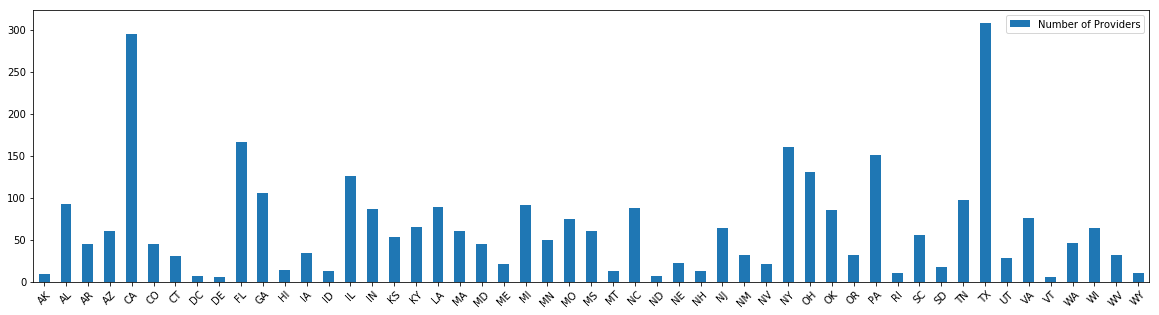

In [9]:
state_plot = results_state_no_hosp_data.plot(kind="bar", figsize=(20,5))
state_plot.set_xticklabels(results_state_no_hosp_data["State"], rotation=45)
plt.show()

### Step 4) State vs Total Number of Discharges per State

Objectives: 
1. Find each state's total number of procedures

In [10]:
# Extract "provider_state" and "total_discharges" from results_df and groupby "provider_state"
results_state_total_discharge = results_df[["provider_state","total_discharges"]]
results_state_total_discharge["total_discharges"] = pd.Series(results_state_total_discharge["total_discharges"])
results_state_total_discharge["total_discharges"] = pd.to_numeric(results_state_total_discharge["total_discharges"], downcast='float')
results_state_total_discharge = results_state_total_discharge[["provider_state","total_discharges"]].groupby(["provider_state"])

# Summing up total_discharges per state
results_state_total_discharge = pd.DataFrame(results_state_total_discharge["total_discharges"].sum())
results_state_total_discharge = results_state_total_discharge.reset_index()
results_state_total_discharge = results_state_total_discharge.rename(columns={"provider_state":"State", "total_discharges":"Number of Discharges"})
#results_state_total_discharge.head()

# Sorting the results by the number of providers by state from highest to lowest
results_state_total_discharge_descend = results_state_total_discharge.sort_values(by="Number of Discharges", ascending = False).reset_index(drop=True)
#results_state_total_discharge_descend.head()n

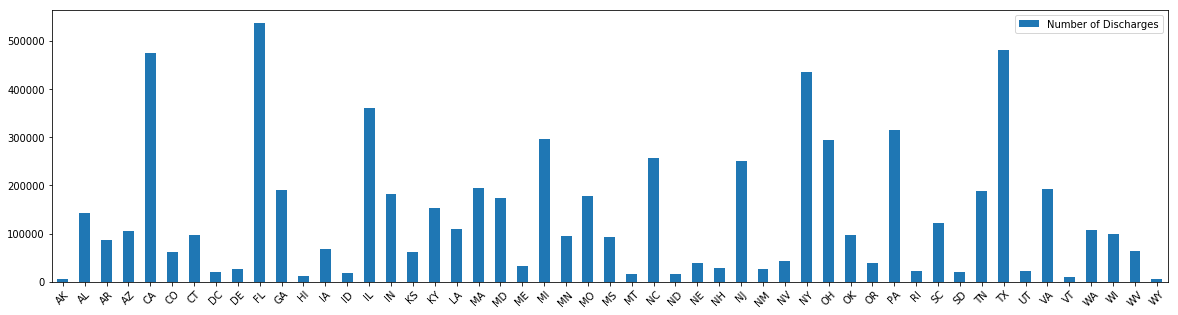

In [11]:
state_plot = results_state_total_discharge.plot(kind="bar", figsize=(20,5))
state_plot.set_xticklabels(results_state_total_discharge["State"], rotation=45)
plt.show()

### Step 5) Number of Providers vs Number of Discharges

Objectives: 
1. Find relationship between Number of Providers and Number of Discharges for each state

In [12]:
results_state_hosp_discharge = pd.merge(results_state_no_hosp_data,results_state_total_discharge, on="State")
results_state_hosp_discharge["Number of Discharges"] = results_state_hosp_discharge["Number of Discharges"]/1000
#results_state_hosp_discharge

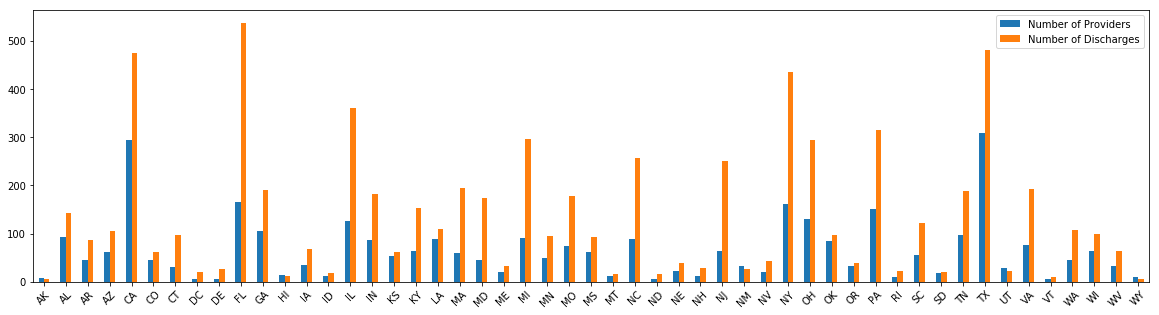

In [13]:
state_hosp_discharge_plot = results_state_hosp_discharge.plot(kind="bar", figsize=(20,5));
state_hosp_discharge_plot.set_xticklabels(results_state_hosp_discharge.State, rotation=45)
plt.show()

### Step 6) State vs Types of Procedures

Objectives: 
1. Find which state does the most number of different types of procedure

In [14]:
# Extract "provider_state" and "drg_definition" from results_df and groupby "provider_state"
results_state_type_proce = results_df[["provider_state","drg_definition"]].groupby(["provider_state"])
results_state_type_proce = pd.DataFrame(results_state_type_proce["drg_definition"].count())
results_state_type_proce = results_state_type_proce.reset_index()
results_state_type_proce = results_state_type_proce.rename(columns = {"provider_state":"State", "drg_definition":"Types of Procedure"})
#results_state_type_proce.head()

# Sorting the results by the drg_definition by state from highest to lowest
results_state_type_proce_desc = results_state_type_proce.sort_values(by="Types of Procedure", ascending = False).reset_index(drop=True)
#results_state_type_proce_desc.head()

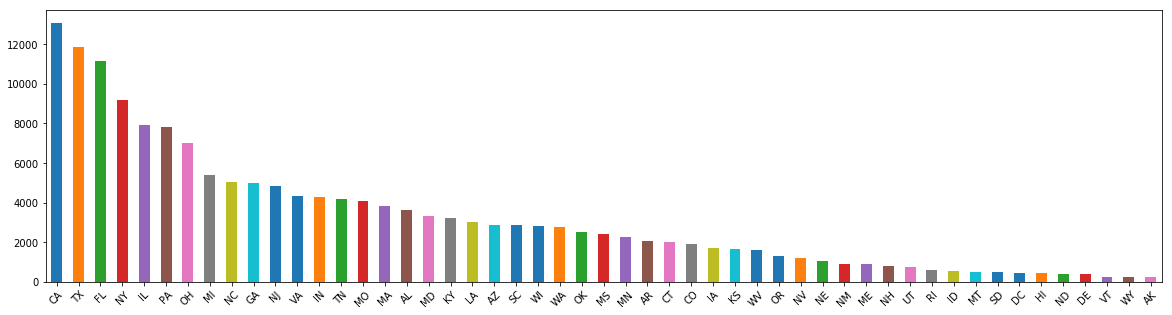

In [15]:
results_state_type_proce_plot = results_state_type_proce_desc["Types of Procedure"].plot(kind="bar", figsize=(20,5))
results_state_type_proce_plot.set_xticklabels(results_state_type_proce_desc["State"], rotation=45)
plt.show()

### Step 7) Each State's Top Procedure

Objectives: 
1. Find which state does what type of procedures the most

In [34]:
# Method 01 exclude tie's

resultGB = results_df.groupby(["provider_state","drg_definition"])#.size().reset_index(name='DRG counts')
drgCtByState = pd.DataFrame(resultGB["provider_id"].count())
drgCtByState.rename(columns = {"provider_id": "Provider Count"}, inplace = True)
drgCtByState["Rank"]= drgCtByState["Provider Count"].rank(method='max')
drgCtByStateRN = drgCtByState.sort_values(by="Rank", ascending = False)
idx = drgCtByStateRN.reset_index().groupby("provider_state")["Provider Count"].idxmax()
drgCtByStateRN.reset_index().loc[idx,].sort_values("provider_state")
result_state_top_proce = results_df.groupby(["provider_state","drg_definition"])
result_state_top_proce = pd.DataFrame(result_state_top_proce["provider_id"].count())
result_state_top_proce.rename(columns = {"provider_id": "Provider Count"}, inplace = True)
result_state_top_proce["Rank"]= drgCtByState["Provider Count"].rank(method='max')
result_state_top_proce = drgCtByState.sort_values(by="Rank", ascending = False)
result_state_top_proce = result_state_top_proce.reset_index().groupby("provider_state")["Provider Count"].idxmax()
result_state_top_proce = drgCtByStateRN.reset_index().loc[idx,].sort_values("provider_state")
del result_state_top_proce["Rank"]
result_state_top_proce = result_state_top_proce.reset_index(drop=True)
result_state_top_proce = result_state_top_proce.rename(columns={"provider_state":"State", "drg_definition":"Procedure Name", "Provider Count":"Procedure Count"})
result_state_top_proce.sort_values(by="Procedure Count", ascending=False).reset_index(drop=True)

,State,Procedure Name,Procedure Count
0,CA,871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ H...,273
1,TX,690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC,255
2,FL,690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC,165
3,NY,292 - HEART FAILURE & SHOCK W CC,158
4,PA,292 - HEART FAILURE & SHOCK W CC,139
5,OH,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,126
6,IL,292 - HEART FAILURE & SHOCK W CC,126
7,GA,194 - SIMPLE PNEUMONIA & PLEURISY W CC,100
8,TN,690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC,95
9,MI,194 - SIMPLE PNEUMONIA & PLEURISY W CC,89


In [44]:
# Method 02 include tie's

resultGB = results_df.groupby(["provider_state","drg_definition"])
drgCtByState = pd.DataFrame(resultGB["provider_id"].count())
drgCtByState.rename(columns = {"provider_id": "Provider Count"}, inplace = True)
drgCtByState["Rank"]= drgCtByState["Provider Count"].rank(method='max')
drgCtByStateRN = drgCtByState.sort_values(by="Rank", ascending = False)
drgCtByStateRNnoMax = drgCtByStateRN.reset_index()

#drgCtByStateRNnoMax
drgCtByStateRNMaxreset = drgCtByStateRN.groupby(["provider_state"]).max().reset_index()
drgCTByStateRNJOIN = pd.merge(drgCtByStateRNMaxreset, drgCtByStateRNnoMax, on=["provider_state", "Provider Count", "Rank"])
del drgCTByStateRNJOIN["Rank"]
drgCTByStateRNJOIN = drgCTByStateRNJOIN[["provider_state","drg_definition","Provider Count"]]
drgCTByStateRNJOIN = drgCTByStateRNJOIN.rename(columns={"provider_state":"State", "drg_definition":"Procedure Name", "Provider Count":"Procedure Count"})
drgCTByStateRNJOIN

,State,Procedure Name,Procedure Count
0,AK,"392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DIS...",8
1,AK,194 - SIMPLE PNEUMONIA & PLEURISY W CC,8
2,AK,603 - CELLULITIS W/O MCC,8
3,AL,690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC,86
4,AR,194 - SIMPLE PNEUMONIA & PLEURISY W CC,43
5,AZ,603 - CELLULITIS W/O MCC,54
6,CA,871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ H...,273
7,CO,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,44
8,CT,177 - RESPIRATORY INFECTIONS & INFLAMMATIONS W...,31
9,CT,683 - RENAL FAILURE W CC,31
